In [5]:
#1. Import dataset
import pandas as pd
train_set_clean_transform= pd.read_csv("train_set_clean_transform.csv")
test_set_clean_transform= pd.read_csv("test_set_clean_transform.csv")

In [6]:
# 4. Check data types of variables
print("\nData types of each column(Train):")
print(train_set_clean_transform.dtypes)
print("\nData types of each column(Test):")
print(test_set_clean_transform.dtypes)


Data types of each column(Train):
seqn                   int64
Age                    int64
Sex                   object
Marital               object
Income               float64
Race                  object
Albuminuria            int64
MetabolicSyndrome      int64
QT_WaistCirc         float64
QT_BMI               float64
QT_UrAlbCr           float64
QT_UricAcid          float64
QT_BloodGlucose      float64
QT_HDL               float64
QT_Triglycerides     float64
dtype: object

Data types of each column(Test):
seqn                   int64
Age                    int64
Sex                   object
Marital               object
Income               float64
Race                  object
Albuminuria            int64
MetabolicSyndrome      int64
QT_WaistCirc         float64
QT_BMI               float64
QT_UrAlbCr           float64
QT_UricAcid          float64
QT_BloodGlucose      float64
QT_HDL               float64
QT_Triglycerides     float64
dtype: object


In [7]:
#6. Identify object type columns
object_cols = train_set_clean_transform.select_dtypes(include=['object']).columns
# Convert object type columns to category
train_set_clean_transform[object_cols] = train_set_clean_transform[object_cols].astype('category')
# Verify the conversion
#print("Data types after conversion:")
#print(train_set_clean_transform.dtypes)
# Optional: Show memory usage before and after conversion
#print("\nMemory usage before conversion:", train_set_clean_transform.memory_usage(deep=True).sum()/1024, "KB")
#7. Convert data types
train_set_clean_transform[['Albuminuria', 'MetabolicSyndrome']] = train_set_clean_transform[['Albuminuria', 'MetabolicSyndrome']].astype('category')
# Verify the conversion
print("Data types after conversion:")
print(train_set_clean_transform.dtypes)


#6. Identify object type columns
object_cols = test_set_clean_transform.select_dtypes(include=['object']).columns
# Convert object type columns to category
test_set_clean_transform[object_cols] = test_set_clean_transform[object_cols].astype('category')
# Verify the conversion
#print("Data types after conversion:")
#print(test_set_clean_transform.dtypes)
# Optional: Show memory usage before and after conversion
#print("\nMemory usage before conversion:", test_set_clean_transform.memory_usage(deep=True).sum()/1024, "KB")
#7. Convert data types
test_set_clean_transform[['Albuminuria', 'MetabolicSyndrome']] = test_set_clean_transform[['Albuminuria', 'MetabolicSyndrome']].astype('category')
# Verify the conversion
print("Data types after conversion:")
print(test_set_clean_transform.dtypes)


Data types after conversion:
seqn                    int64
Age                     int64
Sex                  category
Marital              category
Income                float64
Race                 category
Albuminuria          category
MetabolicSyndrome    category
QT_WaistCirc          float64
QT_BMI                float64
QT_UrAlbCr            float64
QT_UricAcid           float64
QT_BloodGlucose       float64
QT_HDL                float64
QT_Triglycerides      float64
dtype: object
Data types after conversion:
seqn                    int64
Age                     int64
Sex                  category
Marital              category
Income                float64
Race                 category
Albuminuria          category
MetabolicSyndrome    category
QT_WaistCirc          float64
QT_BMI                float64
QT_UrAlbCr            float64
QT_UricAcid           float64
QT_BloodGlucose       float64
QT_HDL                float64
QT_Triglycerides      float64
dtype: object


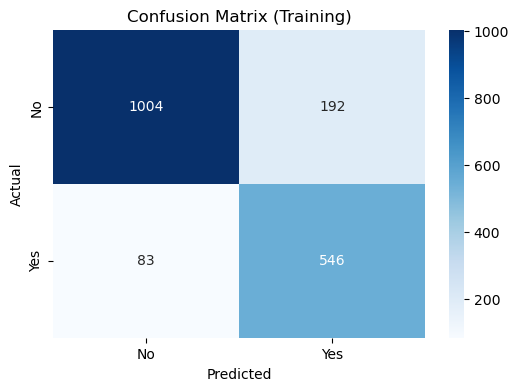

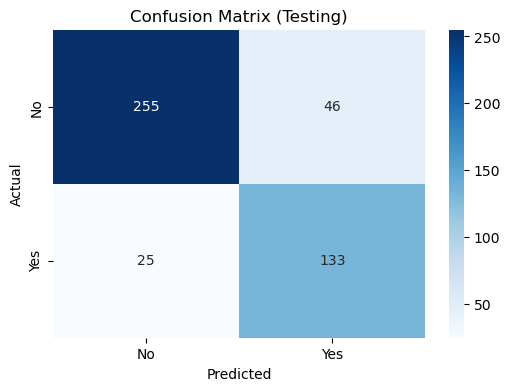


Training Metrics:
                         Value
Accuracy              0.849315
Sensitivity (Recall)  0.868045
Specificity           0.839465
F1 Score              0.798830
AUC-ROC               0.931628

Testing Metrics:
                         Value
Accuracy              0.845316
Sensitivity (Recall)  0.841772
Specificity           0.847176
F1 Score              0.789318
AUC-ROC               0.919130


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================
# 1. DATA PREPARATION
# =============================================

# Separate features and target (assuming seqn is index)
X_train = train_set_clean_transform.drop(['MetabolicSyndrome','seqn','QT_BMI','Income'], axis=1)
y_train = train_set_clean_transform['MetabolicSyndrome'].cat.codes  # Convert to 0/1

X_test = test_set_clean_transform.drop(['MetabolicSyndrome','seqn','QT_BMI','Income'], axis=1)
y_test = test_set_clean_transform['MetabolicSyndrome'].cat.codes

# =============================================
# 2. PREPROCESSING SETUP
# =============================================

# Identify column types
categorical_cols = X_train.select_dtypes(include='category').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers - Note: Not standardizing QT_* variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Only standardizing non-QT numerical variables
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Apply scaling only to non-QT numerical variables
non_qt_numeric = [col for col in numeric_cols if not col.startswith('QT_')]
qt_numeric = [col for col in numeric_cols if col.startswith('QT_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_qt_numeric),
        ('qt_num', 'passthrough', qt_numeric),  # Leave QT_* variables as-is
        ('cat', categorical_transformer, categorical_cols)
    ])

# =============================================
# 3. MODEL PIPELINE
# =============================================

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Handles class imbalance
    ))
])

# Train model
model.fit(X_train, y_train)

# =============================================
# 4. EVALUATION METRICS
# =============================================

def evaluate_model(X, y, dataset_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    sensitivity = recall_score(y, y_pred)  # Recall = Sensitivity
    specificity = recall_score(y, y_pred, pos_label=0)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], 
                yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'F1 Score': f1,
        'AUC-ROC': auc
    }

# Evaluate on both sets
train_metrics = evaluate_model(X_train, y_train, 'Training')
test_metrics = evaluate_model(X_test, y_test, 'Testing')

# Display results
print("\nTraining Metrics:")
print(pd.DataFrame.from_dict(train_metrics, orient='index', columns=['Value']))

print("\nTesting Metrics:")
print(pd.DataFrame.from_dict(test_metrics, orient='index', columns=['Value']))

# =============================================
# 5. ADDITIONAL ANSWERS
# =============================================

#"""
#Q4: Quantile Transformation vs Standardization:
#- Quantile Transformation: Non-linear, maps data to uniform/normal distribution 
 # (already applied to your QT_* variables)
#- Standardization: Linear transformation (x - mean)/std, preserves relationships
 # (applied here to non-QT numerical variables)
  
#Q5: Key Steps Taken:
#1. Proper handling of categorical variables via one-hot encoding
#2. Strategic scaling (standardizing only non-QT variables)
#3. Class imbalance handling via class_weight
#4. Comprehensive evaluation metrics
#5. Clear visualization of results
#"""

C:\Users\Ashani Madushani\AppData\Local\Temp\ipykernel_1500\2527389748.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


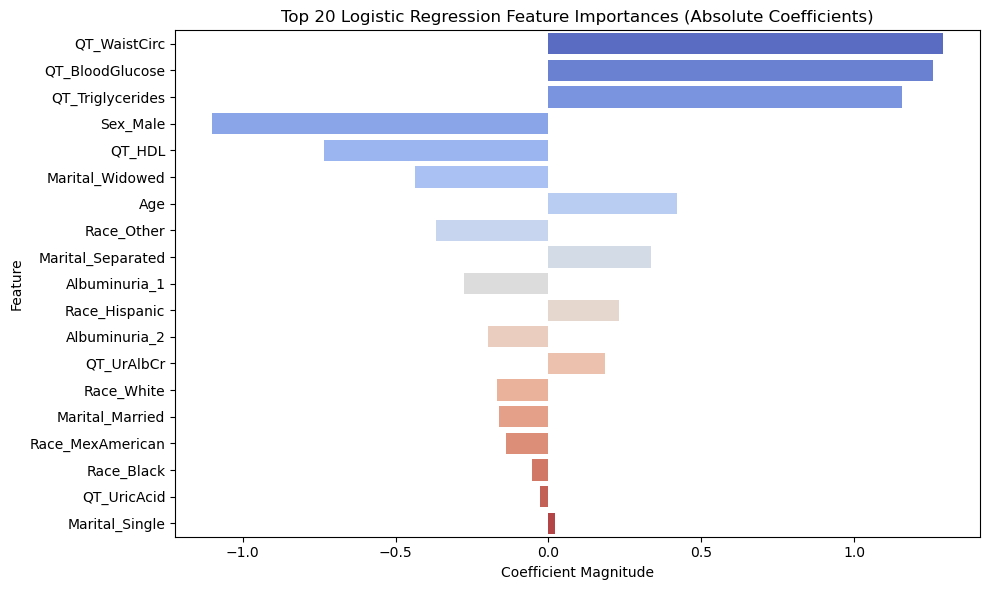


Interpretation Guide:
- Positive coefficients increase probability of MetabolicSyndrome
- Negative coefficients decrease probability of MetabolicSyndrome
- Larger absolute values indicate stronger influence


In [9]:
# Get feature names from the preprocessor
# For numerical features
num_features = non_qt_numeric + qt_numeric

# For categorical features (get one-hot encoded names)
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

# Get coefficients from the logistic regression
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values('Importance', key=abs, ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance.head(20),
    palette='coolwarm'
)
plt.title('Top 20 Logistic Regression Feature Importances (Absolute Coefficients)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Interpretation help
print("\nInterpretation Guide:")
print("- Positive coefficients increase probability of MetabolicSyndrome")
print("- Negative coefficients decrease probability of MetabolicSyndrome")
print("- Larger absolute values indicate stronger influence")